## Imports

In [22]:
from skorch import NeuralNetRegressor
from skorch.callbacks import Checkpoint, EarlyStopping, LRScheduler
from skorch.helper import predefined_split
from skorch.dataset import Dataset

import torch
import torch.nn as nn
from torch.optim.lr_scheduler import ReduceLROnPlateau

import matplotlib.pyplot as plt

import numpy as np

import sys
import os

sys.path.append(os.path.abspath('..'))

from src.models.TurbulenceNetwork import TurbulenceNetwork
from src.data_gens.TurbulenceClosureDataGenerator import TurbulenceClosureDataGenerator
from src.utils.plot_utils import plot_data_generation_diff, plot_heat_map_compare, plot_heat_map_loss, plot_heat_map_3D, plot_grid
from src.utils.model_utils import *
from src.utils.data_utils import *
from src.utils.loss_metric_utils import DiagNLLLoss, BetaNLL

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

DTYPE = torch.float32

print("Device: ", device)

%load_ext autoreload
%autoreload 2

Device:  cuda:0
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data Generation

Out noise


/home/codygrogan/PythonProjects/Uncertainty_Quantification/src/data_gens/TurbulenceClosureDataGenerator.py:89: RuntimeWarning: invalid value encountered in arccos
  theta = np.arccos((-b/2)/np.sqrt(-a**3/27))


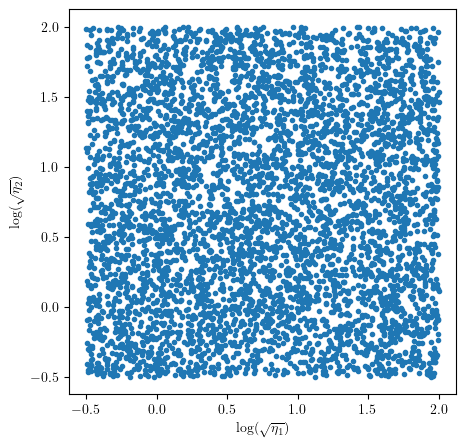

In [23]:
# Data generators for the different turbulence closures
SSG_gen = TurbulenceClosureDataGenerator('SSG')

# Defining the ranges for the different scales
log = (-.5, 2.0)

# Defining whether to exclude certain areas of the data
exclude_area = True
include_area = False
drop_eta_1 = False
drop_eta_2 = False
add_noise = False

# Defining area to exclude datapoints
eta_1_range = np.array([-0.5, 0.0])
eta_2_range = np.array([-.5, 0.0])

etas_train, gs_train = generate_log_data(SSG_gen, log, 5_000, shuffle=True, gen_type="All", noise_type='out_noise', noise = 0.0001, num_samples = 1)

etas_test, gs_test = generate_log_data(SSG_gen, log, 5_000, shuffle=True, gen_type="All")

if not drop_eta_1 and not drop_eta_2:
    plot_data_generation_diff(etas_train)

In [24]:
from sklearn.preprocessing import StandardScaler

# Custom Scaling
x_scaler = CustomScalerX().fit(etas_train)
y_scaler = StandardScaler().fit(gs_train)

x_scaled_train = x_scaler.transform(etas_train)
y_scaled_train = y_scaler.transform(gs_train)

x_train = torch.tensor(x_scaled_train, dtype=DTYPE)
y_train = torch.tensor(y_scaled_train, dtype=DTYPE)

x_test = torch.tensor(x_scaler.transform(etas_test), dtype=DTYPE)
y_test = torch.tensor(y_scaler.transform(gs_test), dtype=DTYPE)

## Network Training

In [25]:
# Defining model parameters
chkpt_dir = '../Model_Checkpoints/MCD/Aleatoric_Low_5k/'
chkpt_prefix = 'Regular_Aleatoric_5k_'

net_params = {
        "input_dim": 2,
        "output_dim": 3,
        "num_layers": 4,
        "h_dim": 20,
        "dropout": [0.001, 0.001, 0.001],
        "out_noise": "homoscedastic",
        'out_noise_scale' : 1.0,
}

train_params = {
        "criterion": BetaNLL,
        "criterion__beta": 0.0,
        "optimizer": torch.optim.Adam,
        #"optimizer__weight_decay": 1e-7,
        "lr": 0.001,
        "batch_size": 512,
        "max_epochs": 1000,
        "device": device,
        "iterator_train__shuffle": True,
        "iterator_train__pin_memory": True,
        "train_split": predefined_split(Dataset(x_test, y_test)),
        "verbose": 2,
        'warm_start' : True,
}


In [26]:
net_name = chkpt_prefix + 'MCD1'

callbacks = [
        EarlyStopping(patience=15, threshold=0.000001, threshold_mode='abs', monitor='valid_loss', lower_is_better=True),
        Checkpoint(monitor='valid_loss_best', f_params=net_name+'.pt', dirname=chkpt_dir),
        LRScheduler(policy=ReduceLROnPlateau, monitor='valid_loss', factor=0.5, patience=5, threshold=0.000001, threshold_mode='abs', mode='min')
]
train_params['callbacks'] = callbacks


net = create_skorch_model(TurbulenceNetwork, NeuralNetRegressor, net_params, train_params)

net = net.fit(x_train, y_train)

net.load_params(f_params=chkpt_dir+net_name+'.pt')
test_pred = net.predict(x_test)

  epoch    train_loss    valid_loss    cp      lr     dur
-------  ------------  ------------  ----  ------  ------
      1      774.6466      674.6049     +  0.0010  0.0541
      2      747.0128      651.5055     +  0.0010  0.0440
      3      723.5739      627.5842     +  0.0010  0.0414
      4      692.5417      597.5313     +  0.0010  0.0389
      5      663.3606      564.3285     +  0.0010  0.0378
      6      626.4878      527.9183     +  0.0010  0.0410
      7      579.1826      481.6048     +  0.0010  0.0388
      8      529.5982      423.0744     +  0.0010  0.0433
      9      454.4682      353.1233     +  0.0010  0.0416
     10      369.4055      272.2495     +  0.0010  0.0389
     11      276.5456      193.6312     +  0.0010  0.0397
     12      196.8080      124.6854     +  0.0010  0.0410
     13      122.6665       61.1536     +  0.0010  0.0383
     14       56.4499        2.3138     +  0.0010  0.0386
     15       -3.7810      -51.8532     +  0.0010  0.0398
     16      -

In [27]:
sigmas = net.module.sigma.detach().cpu().numpy()

sigmas = sigmas * y_scaler.scale_  # Scale back to original scale
#sigmas = np.sqrt(np.exp(sigmas))* y_scaler.scale_  # Scale back to original scale

print(sigmas)

[[0.00304343 0.00204253 0.00195014]]


## Reinitializing Trained Model

In [28]:
dir_prefix = 'Aleatoric_Low_5k'
chkpt_prefix = 'Regular_Aleatoric_5k'
chkpt_dir = '../Model_Checkpoints/MCD/' + dir_prefix + '/'
data_dir = '../data/MCD/' + dir_prefix + '/'
net = create_skorch_model(TurbulenceNetwork, NeuralNetRegressor, net_params, train_params)
net = reinitialize_model(chkpt_dir + chkpt_prefix + '_MCD1.pt', net)


Re-initializing module.
Re-initializing criterion because the following parameters were re-set: beta.
Re-initializing optimizer.


## Generating Statistics Data

MAE:  0.0007939884034394288


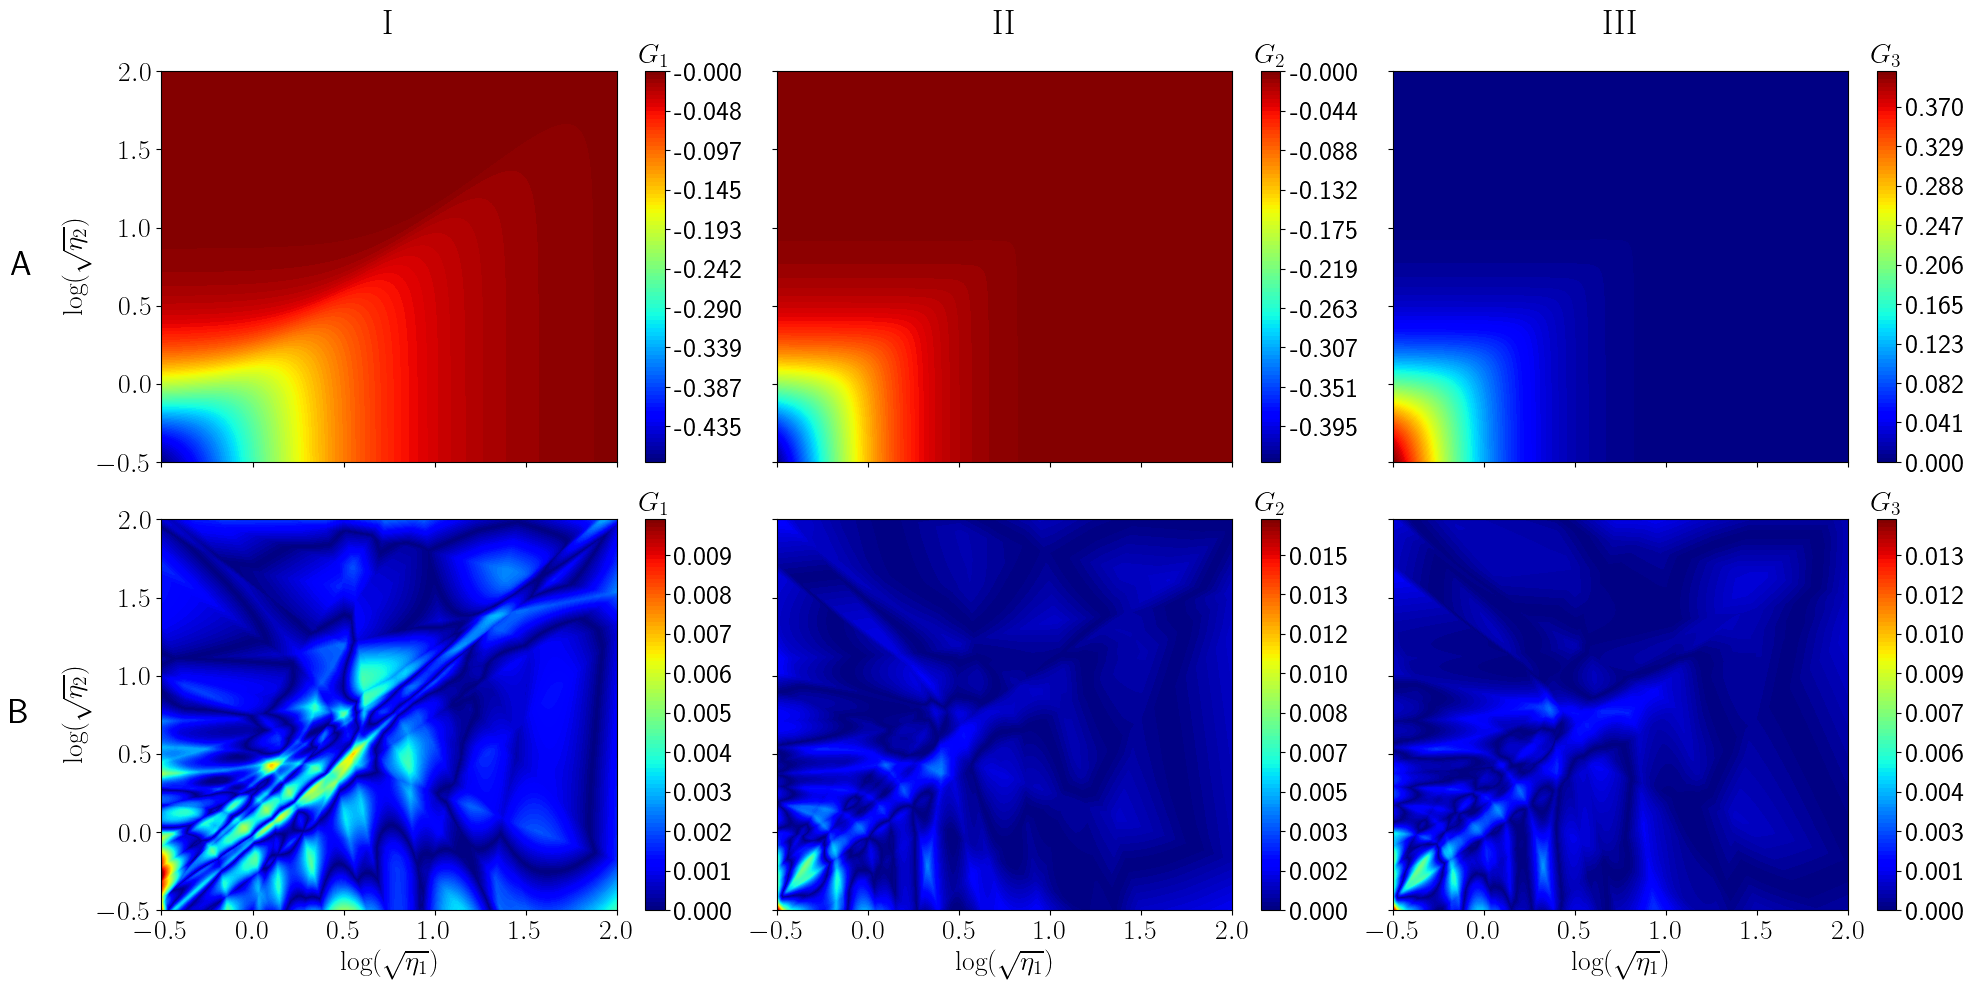

In [29]:
dim = 700
x_grid, y_grid = np.meshgrid(np.linspace(*log, dim),np.linspace(*log, dim))
eta1 = (10**x_grid.flatten())**2
eta2 = (10**y_grid.flatten())**2

gen = TurbulenceClosureDataGenerator(model="SSG", type='torch')
etas, G_s = gen(eta1, eta2)
target = G_s.T.reshape(3, dim, dim)

etas = x_scaler.transform(etas)

pred = net.predict(etas.astype(np.float32))

pred = y_scaler.inverse_transform(pred)

pred = pred.T.reshape(3, dim, dim)

print("MAE: ", np.mean(np.abs(pred-target)))


row_titles = ["A", "B", "C"]
col_titles = [r"$\mathrm{I}$", r"$\mathrm{II}$", r"$\mathrm{III}$"]

formatter = lambda x, pos: f"{x:>6.3f}"

plot_grid(x_grid, y_grid, [target, np.abs(pred-target)], row_titles, col_titles, formatter, figsize=(20,10), ind_scales=True)

## Generating Model Uncertainty From Dropout

In [30]:
torch.cuda.empty_cache()

T = 200
predictions = np.zeros((T, dim*dim, 3))
if "out_noise" in net_params and net_params["out_noise"] == "heteroscedastic":
    stds = np.zeros((T, dim*dim, 3))

batch_size = dim*dim // 4
batch_idx = np.arange(0, dim*dim + batch_size, batch_size)

net.module.dropout_on()

for i in range(T):
    batches_pred = np.zeros((len(etas)//batch_size, batch_size , 3))
    batch_std = np.zeros((len(etas)//batch_size, batch_size , 3))
    for j in range(len(batch_idx)-1):
        input = torch.tensor(etas[batch_idx[j]:batch_idx[j+1]], dtype=torch.float32).to(device)
        out = net.module(input)
        if "out_noise" in net_params and net_params["out_noise"] == "heteroscedastic":
            batches_pred[j] = out[0].cpu().detach().numpy()
            batch_std[j] = out[1].cpu().detach().numpy()
        else:
            batches_pred[j] = net.module(input, noise=False).cpu().detach().numpy()
    if "out_noise" in net_params and net_params["out_noise"] == "heteroscedastic":
        stds[i] = batch_std.reshape(dim*dim, 3)
        predictions[i] = batches_pred.reshape(dim*dim, 3)
    else:
        predictions[i] = y_scaler.inverse_transform(batches_pred.reshape(dim*dim, 3))

In [31]:
mean_pred = np.mean(predictions, axis=0)

std_pred = np.std(predictions, axis=0)

if "out_noise" in net_params and net_params["out_noise"] == "homoscedastic":
    sigmas = net.module.sigma.cpu().detach().numpy()* y_scaler.scale_  # Scale back to original scale
    print(f"Sigmas: {sigmas}")
    std_pred = np.sqrt(std_pred**2 + sigmas**2)
    np.savetxt(data_dir + chkpt_prefix + '_Sigmas.csv', sigmas, delimiter=',')
if "out_noise" in net_params and net_params["out_noise"] == "heteroscedastic":
    obs_noise = stds.mean(axis=0)
    obs_noise = np.mean(obs_noise, axis=0)
    print(f"Obs noise: {obs_noise}")

np.savetxt(data_dir + chkpt_prefix + '_Pred_Mean.csv', mean_pred, delimiter=',')
np.savetxt(data_dir + chkpt_prefix + '_Pred_Std.csv', std_pred, delimiter=',')

Sigmas: [[0.00304343 0.00204253 0.00195014]]


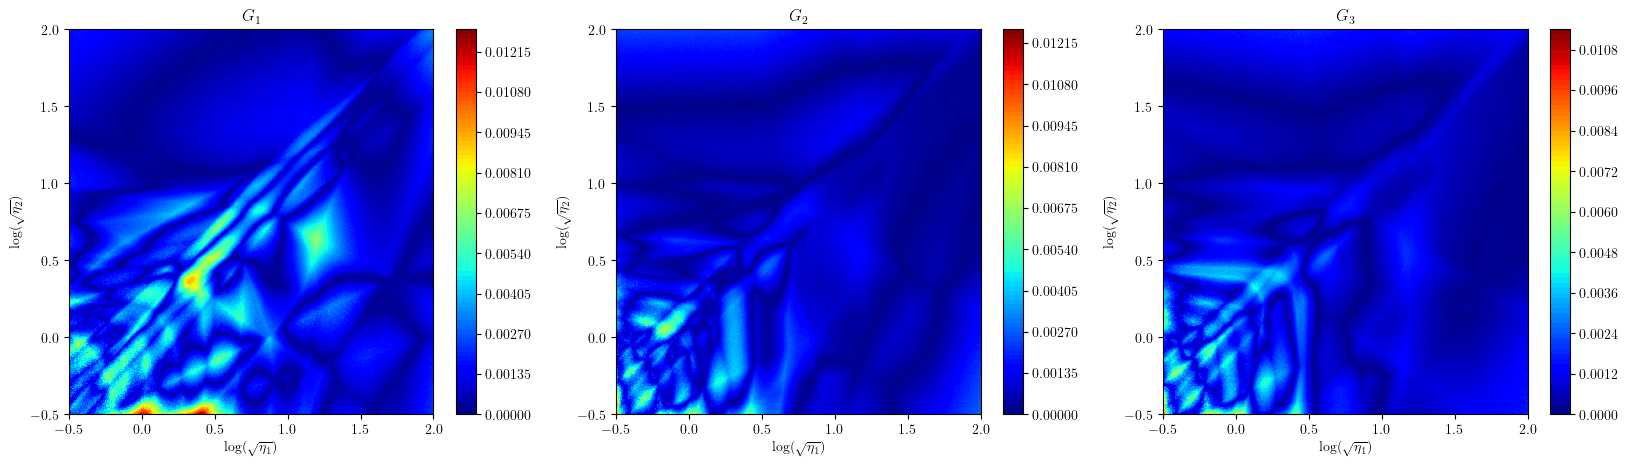

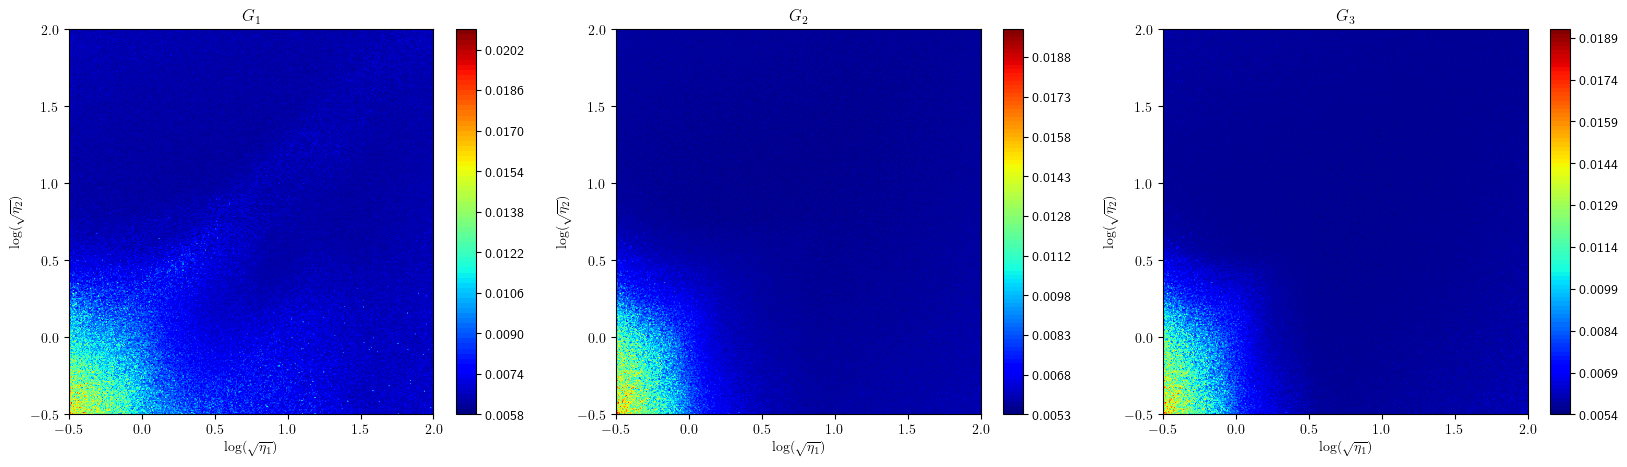

In [19]:
plot_heat_map_loss(x_grid, y_grid, target, mean_pred.T.reshape(3, dim, dim))

plot_heat_map_3D(x_grid, y_grid, std_pred.T.reshape(3, dim, dim), title="MC Dropout Standard Deviation", sup_title=False)

Predicted Std: [[0.00584902 0.00538681 0.00543261]]
Mean Residual: [ 0.0003877   0.0001769  -0.00029683]
Mean of Residual: [ 0.0003877   0.0001769  -0.00029683]
Std Residual: [0.00235397 0.00153319 0.00156548]
Sharpness: [0.00175694 0.00148828 0.00139609]
Mean Residual std: [0.03402416 0.01537713 0.01449141]


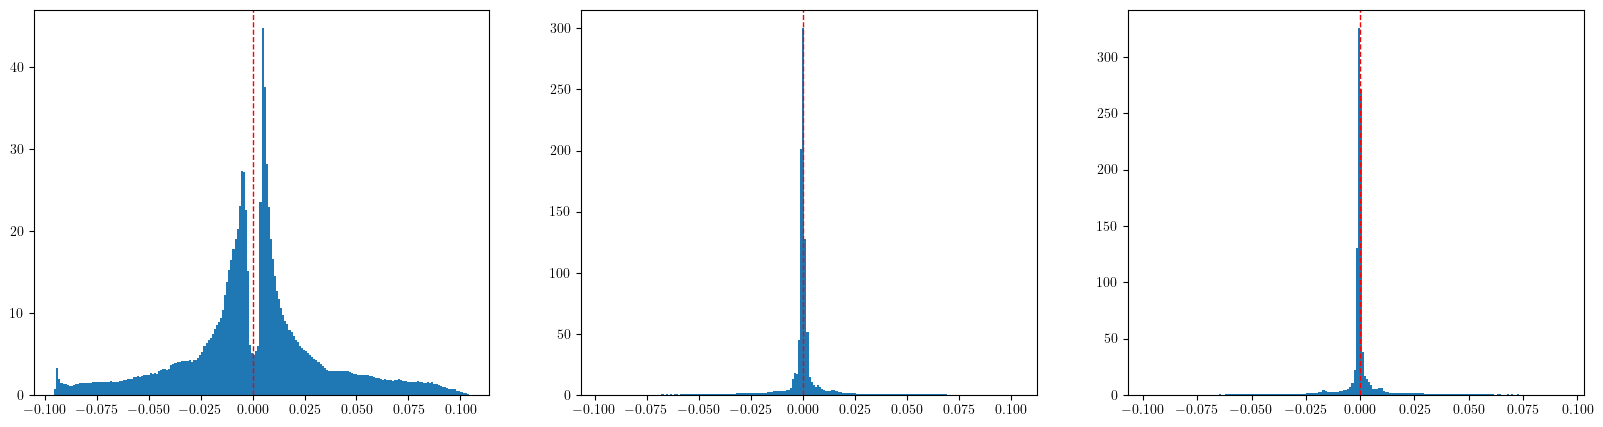

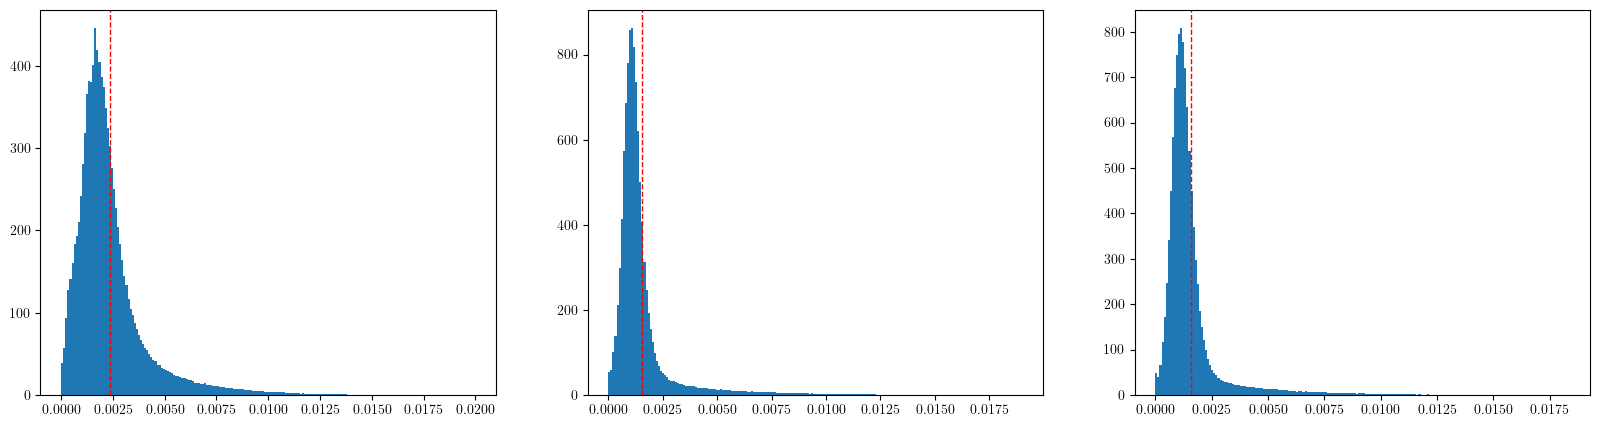

In [20]:
mean_resid = mean_pred - target.T.reshape(-1, 3)
resid = predictions - target.T.reshape(-1, 3)

resid_std = np.std(resid, axis=0)
resid_mean = np.mean(resid, axis=0)
mean_resid_std = np.std(mean_resid, axis=0)

print(f"Predicted Std: {sigmas}")
print(f"Mean Residual: {np.mean(mean_resid, axis=0)}")
print(f"Mean of Residual: {np.mean(resid_mean, axis=0)}")
print(f"Std Residual: {np.mean(resid_std, axis=0)}")
print(f"Sharpness: {np.std(resid_std, axis=0)}")
print(f"Mean Residual std: {mean_resid_std}")

fig, ax = plt.subplots(1, 3, figsize=(20, 5))
ax[0].hist(mean_resid[:, 0], bins=200, density=True)
ax[1].hist(mean_resid[:, 1], bins=200, density=True)
ax[2].hist(mean_resid[:, 2], bins=200, density=True)

ax[0].axvline(mean_resid[:, 0].mean(), color='r', linestyle='dashed', linewidth=1)
ax[1].axvline(mean_resid[:, 1].mean(), color='r', linestyle='dashed', linewidth=1)
ax[2].axvline(mean_resid[:, 2].mean(), color='r', linestyle='dashed', linewidth=1)

plt.show()

fig, ax = plt.subplots(1, 3, figsize=(20, 5))
ax[0].hist(resid_std[:, 0], bins=200, density=True)
ax[1].hist(resid_std[:, 1], bins=200, density=True)
ax[2].hist(resid_std[:, 2], bins=200, density=True)

ax[0].axvline(resid_std[:, 0].mean(), color='r', linestyle='dashed', linewidth=1)
ax[1].axvline(resid_std[:, 1].mean(), color='r', linestyle='dashed', linewidth=1)
ax[2].axvline(resid_std[:, 2].mean(), color='r', linestyle='dashed', linewidth=1)

plt.show()

(5000, 3)
Predicted std: [[0.00584902 0.00538681 0.00543261]]
Training Resid Std: [0.00604245 0.00538713 0.00541244]


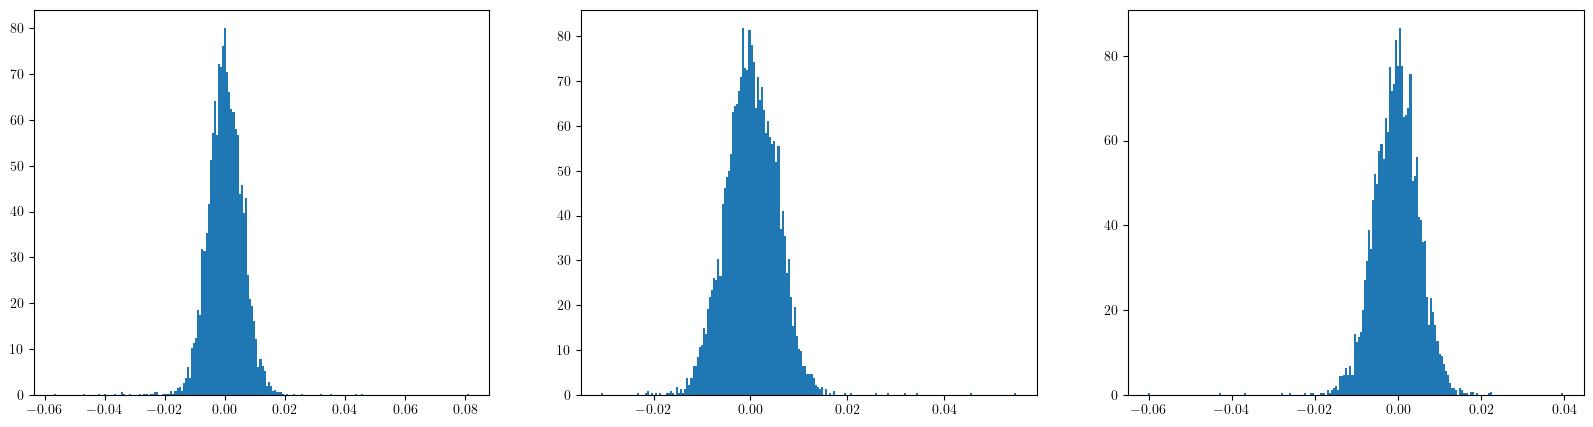

In [21]:
preds_train = net.module(x_train.to(device), False).cpu().detach().numpy()
preds_train = y_scaler.inverse_transform(preds_train)

print(preds_train.shape)

resid = preds_train - gs_train

resid_std = np.std(resid, axis=0)

print(f"Predicted std: {sigmas}")
print(f"Training Resid Std: {resid_std}")

fig, ax = plt.subplots(1, 3, figsize=(20, 5))
ax[0].hist(resid[:, 0], bins=200, density=True)
ax[1].hist(resid[:, 1], bins=200, density=True)
ax[2].hist(resid[:, 2], bins=200, density=True)

plt.show()